
# Time Series Forecasting using Prophet

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
import datetime

# Data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy

# Set font scale and style
plt.rcParams.update({'font.size': 18})

# Facebook prophet
from prophet import Prophet

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import custom class
%run -i '../src/helper/ts_analysis.py'

In [3]:
# Instantiate the class
fxn = TimeSeriesAnalysis()

# Load  data

In [4]:
ts = pd.read_csv('../data/collision_ts_month.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (228, 9)


,fatality_rate,med_fatal,med_injury,med_no_injury,not-head-on,head-on,year,month,summer_ind
date,,,,,,,,,
1999-01-01,0.013067,85.0,99.0,48.0,108.0,124.0,1999,1,0
1999-02-01,0.017570,101.0,108.0,40.0,93.0,156.0,1999,2,0
1999-03-01,0.021727,105.0,170.0,48.0,96.0,227.0,1999,3,0
1999-04-01,0.013606,99.0,84.0,32.0,44.0,171.0,1999,4,0
1999-05-01,0.018343,150.0,165.0,53.0,79.0,289.0,1999,5,0


#  Create a Test  Set
As we saw above, we used the entire observation of the data set to identify the model. However, we would like to show how to use the model to make short-term forecasts. Therefore, we must split the data set into training and test set; we have chosen the test set as the last three year's observations (i.e. 2013-2016).


In [5]:
train_start, train_end = '1999-01-01','2016-12-01'
test_start, test_end = '2017-01-01', '2017-12-01'

X_train = ts.drop('fatality_rate', axis =1)[train_start: train_end]
y_train = ts['fatality_rate'][train_start: train_end]

X_test = ts.drop('fatality_rate', axis =1)[test_start: test_end]
y_test = ts['fatality_rate'][test_start: test_end]

# Normalization

In [6]:
# Standardization
scaler_y = StandardScaler() 
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)) 

# Normalization 
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Pandas dataframe
y_train_df = pd.DataFrame(y_train_scaled, columns=['y'], index = y_train.index)
X_train_df = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_train_df.insert(0,'y', y_train_df.y.values)
X_train_df.insert(0,'ds', y_train.index)
X_test_df.insert(0,'ds', y_test.index)

# Prophet Model

In [7]:
# Train Prophet
model = Prophet(changepoint_prior_scale=0.01, seasonality_mode='additive',
            yearly_seasonality=10, 
            weekly_seasonality=True, 
            daily_seasonality=False)
model.add_seasonality(name='monthly', period=30, fourier_order=5)

for col in X_train.columns: 
    model.add_regressor(col, mode='additive')
model.fit(X_train_df)

# Make forecast
forecast = model.predict(X_test_df)
yhat = forecast['yhat'].values
yhat = scaler_y.inverse_transform(yhat.reshape(-1,1)).flatten()

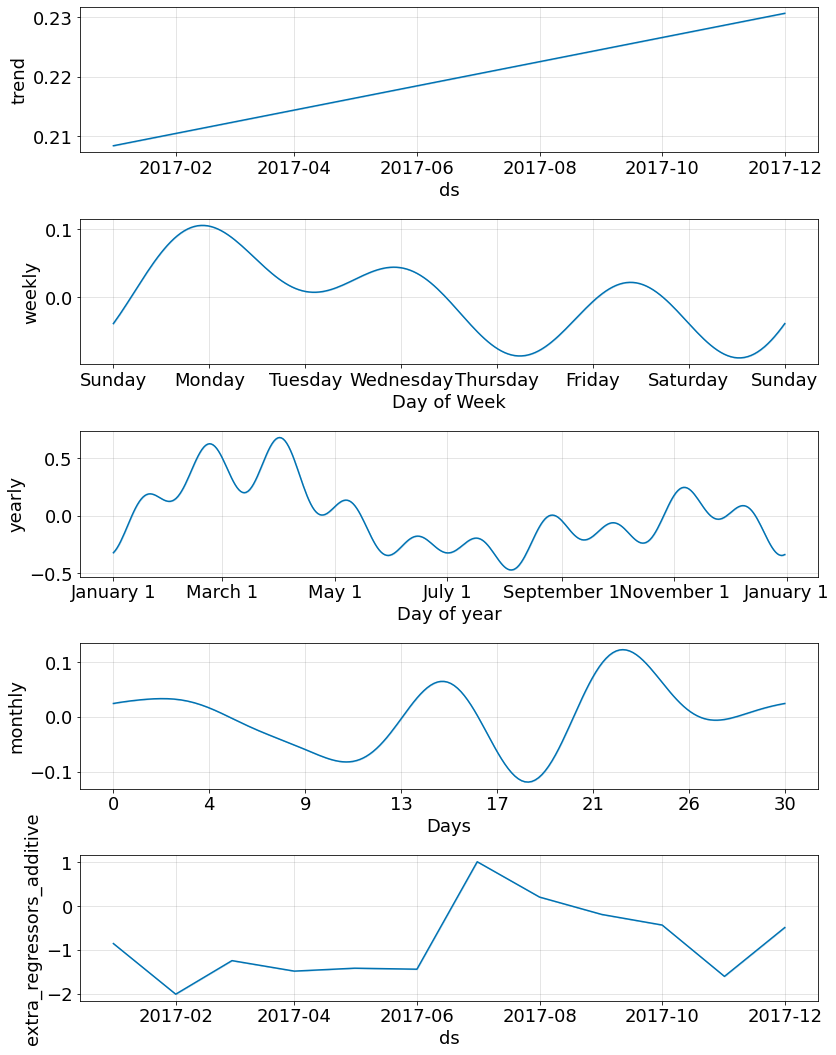

In [8]:
fig = model.plot_components(forecast, figsize = (12,15))

# Performance measures

In [9]:
fxn.error_metrics(y_test, yhat)

{'MAE = 0.001', 'MAPE = 8.612', 'RMSE = 0.001', 'R^2 = 0.825'}

In [10]:
yhat[yhat<0] = 0

ylow = forecast['yhat_lower'].values
ylow = scaler_y.inverse_transform(ylow.reshape(-1,1)).flatten()
ylow[ylow<0] = 0

yhigh = forecast['yhat_upper'].values
yhigh = scaler_y.inverse_transform(yhigh.reshape(-1,1)).flatten()
yhigh[yhigh<0] = 0

results = pd.DataFrame()
results['yhat'] = yhat
results['ylow'] = ylow
results['yhigh'] = yhigh
results.index = y_test.index

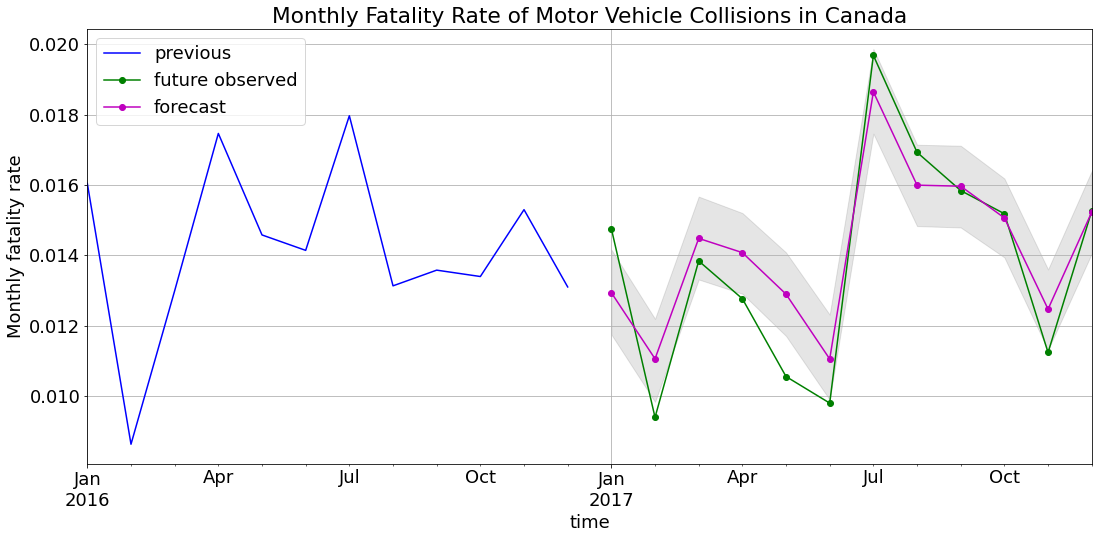

In [11]:
plt.figure(figsize = (18,8))

y_train.iloc[-len(y_test):].plot(label = 'previous', color = 'b')
y_test.plot(label = 'future observed', marker = 'o', color = 'g')
results['yhat'].plot(label = 'forecast', marker = 'o', color = 'm')

plt.fill_between(results.index, results['ylow'], results['yhigh'], color='k', alpha=0.1)
plt.xlabel('time')
plt.grid(True)
plt.ylabel('Monthly fatality rate')
plt.title('Monthly Fatality Rate of Motor Vehicle Collisions in Canada')
plt.legend()
plt.savefig('../images/propt.png')
plt.show()

# Test set error

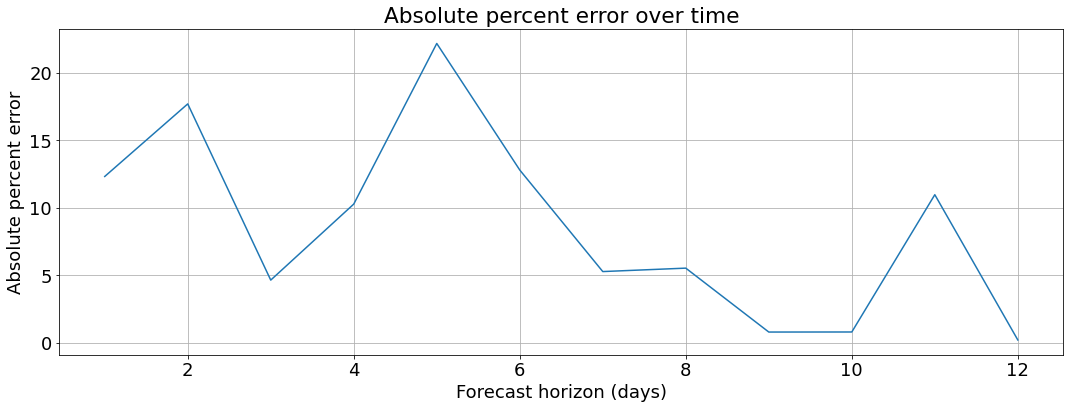

In [12]:
plt.figure(figsize = (18,6))
abs_err = 100*np.abs((yhat - y_test.values)/(y_test.values))

plt.plot(np.arange(1, len(abs_err)+1), abs_err)
plt.grid(True)
plt.xlabel('Forecast horizon (days)')
plt.ylabel('Absolute percent error')
plt.title('Absolute percent error over time')
plt.show()